# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None

################################################################################
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

iterations = 1500
num_tries = 500

for i in xrange(num_tries):
    # To avoid grid search, let each learning rate have its own set of regularization strengths
    lr = 10 ** np.random.uniform(-10, -5)
    reg = 10 ** np.random.uniform(3, 9)
    
    print '({}/{}) learning_rate: {} regularization_strength: {} ...'.format(i, num_tries, lr, reg)
        
    # Create and train the SVM
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=iterations)
        
    # Evaluate accuracy and store results
    training_accuracy = np.mean(y_train == svm.predict(X_train_feats))
    validation_accuracy = np.mean(y_val == svm.predict(X_val_feats))
        
    results[(lr, reg)] = (training_accuracy, validation_accuracy)
        
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results, sorted by validation accuracy
for lr, reg in sorted(results, key=lambda x: results[x][1]):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

(0/500) learning_rate: 7.23406682449e-10 regularization_strength: 423315.008888 ...
(1/500) learning_rate: 1.01522610265e-06 regularization_strength: 23321301.6528 ...


cs231n/classifiers/linear_svm.py:96: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(np.square(W))
cs231n/classifiers/linear_svm.py:96: RuntimeWarning: overflow encountered in square
  loss += 0.5 * reg * np.sum(np.square(W))
cs231n/classifiers/linear_svm.py:114: RuntimeWarning: overflow encountered in multiply
  dW = (X.T.dot(intermediate) / N) + reg * W
cs231n/classifiers/linear_svm.py:108: RuntimeWarning: invalid value encountered in greater
  intermediate = (margins > 0) * 1.0  # * 1.0 converts boolean to float
cs231n/classifiers/linear_classifier.py:72: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


(2/500) learning_rate: 3.73323185422e-07 regularization_strength: 28723122.4644 ...


cs231n/classifiers/linear_svm.py:89: RuntimeWarning: invalid value encountered in subtract
  margins = np.maximum(0, scores - correct_class_scores.reshape(-1, 1) + 1)


(3/500) learning_rate: 5.24794544868e-08 regularization_strength: 320005.3942 ...
(4/500) learning_rate: 2.05971224353e-08 regularization_strength: 1527.64156936 ...
(5/500) learning_rate: 9.76111661405e-10 regularization_strength: 78476586.9383 ...
(6/500) learning_rate: 2.9853733295e-08 regularization_strength: 11491.2726042 ...
(7/500) learning_rate: 5.92946315084e-09 regularization_strength: 1385.67054363 ...
(8/500) learning_rate: 6.37714372746e-09 regularization_strength: 1586598.96496 ...
(9/500) learning_rate: 1.61990049103e-07 regularization_strength: 67653110.257 ...
(10/500) learning_rate: 5.45144028442e-08 regularization_strength: 311110.415555 ...
(11/500) learning_rate: 1.18567775852e-07 regularization_strength: 3972.48755878 ...
(12/500) learning_rate: 5.70915482435e-08 regularization_strength: 4891.08193273 ...
(13/500) learning_rate: 1.75749822613e-09 regularization_strength: 45967203.6274 ...
(14/500) learning_rate: 1.53952107983e-06 regularization_strength: 833750.53

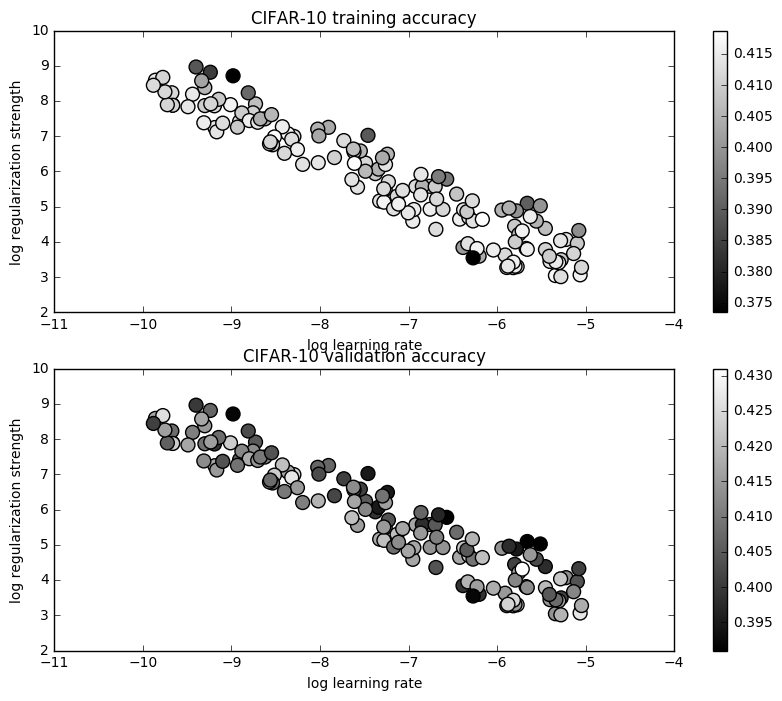

In [5]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results if results[x][1] > 0.39]
y_scatter = [math.log10(x[1]) for x in results if results[x][1] > 0.39]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results if results[x][1] > 0.39]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results if results[x][1] > 0.39] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [6]:
from scipy import stats

# Do a linear regression on lr-reg correlation
x_scatter = [math.log10(x[0]) for x in results if results[x][1] > 0.39]
y_scatter = [math.log10(x[1]) for x in results if results[x][1] > 0.39]

slope, intercept, r_value, p_value, std_err = stats.linregress(x_scatter, y_scatter)
print slope, intercept, r_value, p_value, std_err

-1.10044415265 -2.2376357945 -0.947776469184 2.34111722369e-71 0.0312968580483


In [7]:
# Use the validation set to tune the learning rate and regularization strength

results = {}
best_val = -1
best_svm = None

################################################################################
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

iterations = 5000
num_tries = 100

for i in xrange(num_tries):
    # To avoid grid search, let each learning rate have its own set of regularization strengths
    lr_log = np.random.uniform(-3, -1.9)
    lr = 10 ** lr_log
    reg = 10 ** (slope * lr_log + intercept + np.random.rand())
    
    print '({}/{}) learning_rate: {} regularization_strength: {} ...'.format(i, num_tries, lr, reg)
        
    # Create and train the SVM
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=iterations)
        
    # Evaluate accuracy and store results
    training_accuracy = np.mean(y_train == svm.predict(X_train_feats))
    validation_accuracy = np.mean(y_val == svm.predict(X_val_feats))
        
    results[(lr, reg)] = (training_accuracy, validation_accuracy)
        
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results, sorted by validation accuracy
for lr, reg in sorted(results, key=lambda x: results[x][1]):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

(0/100) learning_rate: 0.00398451266207 regularization_strength: 4.80778134102 ...
(1/100) learning_rate: 0.00161558991496 regularization_strength: 21.4777536809 ...
(2/100) learning_rate: 0.00109430192322 regularization_strength: 71.7174483558 ...
(3/100) learning_rate: 0.00227010235618 regularization_strength: 5.08172393047 ...
(4/100) learning_rate: 0.00793599311788 regularization_strength: 1.92594920846 ...
(5/100) learning_rate: 0.00136714591384 regularization_strength: 20.3729589925 ...
(6/100) learning_rate: 0.00102475221331 regularization_strength: 60.5557907456 ...
(7/100) learning_rate: 0.0090122115285 regularization_strength: 5.63534888403 ...
(8/100) learning_rate: 0.00628919643626 regularization_strength: 6.29378531438 ...
(9/100) learning_rate: 0.00132396493876 regularization_strength: 9.73180841312 ...
(10/100) learning_rate: 0.00194985562122 regularization_strength: 10.7719744675 ...
(11/100) learning_rate: 0.0115327740194 regularization_strength: 0.993845254519 ...
(12

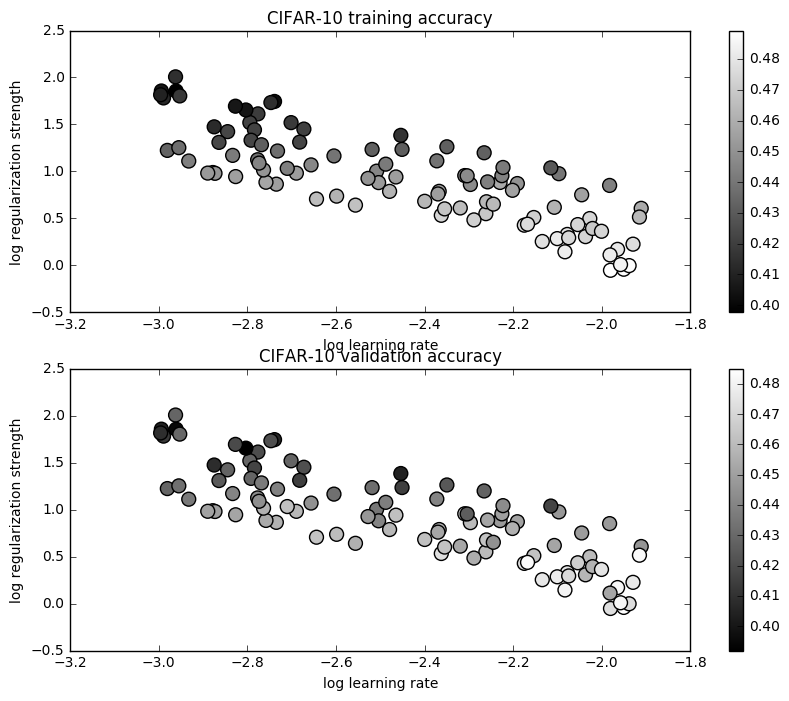

In [8]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.485


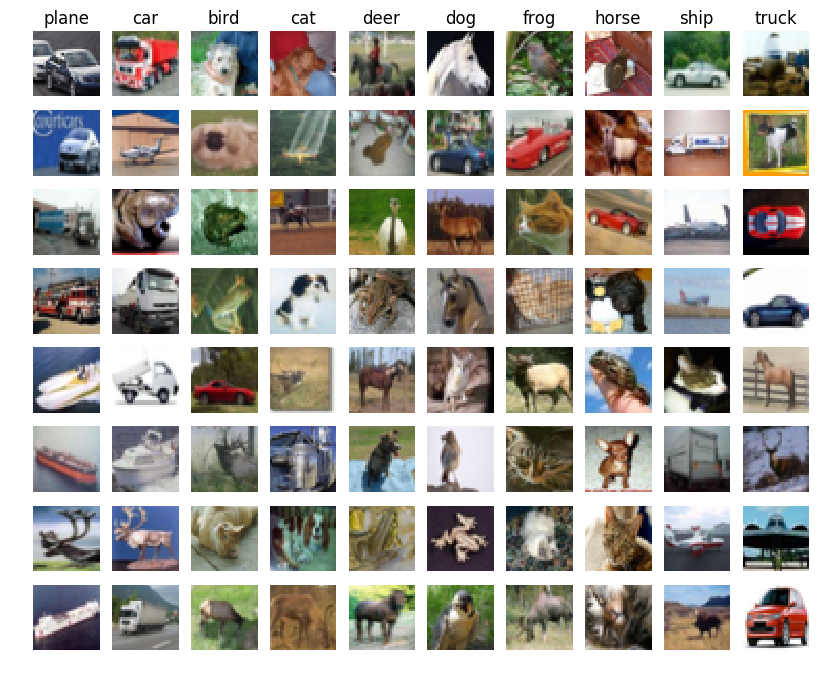

In [10]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

*Yes. Although misclassifications in some classes are harder interpret than in others, we can notice some very obvious common patterns, for example, most misclassifications in 'plane' and 'ship' have a subject on a blue background, 'car' misclassifications feature mostly straight lines, the 'truck' ones feature cars and/or beige colors, 'cats' feature warm, reddish fur-like colors etc.*

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [11]:
print X_train_feats.shape

(49000, 155)


In [12]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
num_classes = 10

best_net = None

################################################################################
# Train a two-layer neural network on image features. You may want to          #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

from time import time

hidden_size = 256
batch_size = 2000
epochs = 30
iterations = int((50000/batch_size) * epochs)
networks = 15

best_val = -1
results = []

# Timing stuff
time_info = ''
tics = []

for i in xrange(networks):
    # Store current time in list for time estimation
    tics.append(time())
    
    # Pick a random learning rate and regularization strength
    lr = 10 ** np.random.uniform(0.35, 0.6)
    reg = 10 ** np.random.uniform(-8, -4)
    
    # Output
    print '{}/{} ... {}'.format(i+1, networks, time_info)
    
    # Create and train a network
    net = TwoLayerNet(input_dim, hidden_size, num_classes, dropout=True)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                      num_iters=iterations, batch_size=batch_size,
                      learning_rate=lr, learning_rate_decay=0.95,
                      reg=reg, verbose=False)
    
    # Evaluate the network
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    train_acc = (net.predict(X_train_feats) == y_train).mean()
    
    results.append((lr, reg, train_acc, val_acc, net))
    
    if val_acc > best_val:
        best_val = val_acc
        best_net = net
        best_stats = stats
    
    # Calculate time remaining estimate
    if len(tics) > 1:
        toc = time()
        time_elapsed = toc - tics[0]
        time_remaining = (toc - tics[i-1])/2 * (networks - i - 1)
        time_info = 'time elapsed: {:.2f}s estimated time remaining: {:.2f}s'.format(time_elapsed, time_remaining)
    
print '\n total elapsed time: {}s\n'.format(time() - tics[0])
    
# Print results in order
results = sorted(results, key=lambda x: x[3], reverse=True)
for i in xrange(len(results)):
    lr, reg, t_a, v_a, _ = results[i]
    print '%i lr %e reg %e train accuracy: %f val accuracy: %f' % (i+1, lr, reg, t_a, v_a)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

1/15 ... 
2/15 ... 
3/15 ... time elapsed: 59.37s estimated time remaining: 385.89s
4/15 ... time elapsed: 89.48s estimated time remaining: 364.16s
5/15 ... time elapsed: 121.89s estimated time remaining: 343.84s
6/15 ... time elapsed: 150.65s estimated time remaining: 305.86s
7/15 ... time elapsed: 178.59s estimated time remaining: 255.16s
8/15 ... time elapsed: 207.22s estimated time remaining: 226.27s
9/15 ... time elapsed: 235.62s estimated time remaining: 199.63s
10/15 ... time elapsed: 264.90s estimated time remaining: 173.03s
11/15 ... time elapsed: 294.65s estimated time remaining: 147.57s
12/15 ... time elapsed: 325.93s estimated time remaining: 122.05s
13/15 ... time elapsed: 357.16s estimated time remaining: 93.76s
14/15 ... time elapsed: 386.76s estimated time remaining: 60.83s
15/15 ... time elapsed: 417.73s estimated time remaining: 30.28s

 total elapsed time: 446.296689987s

1 lr 3.338424e+00 reg 4.173797e-08 train accuracy: 0.688020 val accuracy: 0.619000
2 lr 3.112958

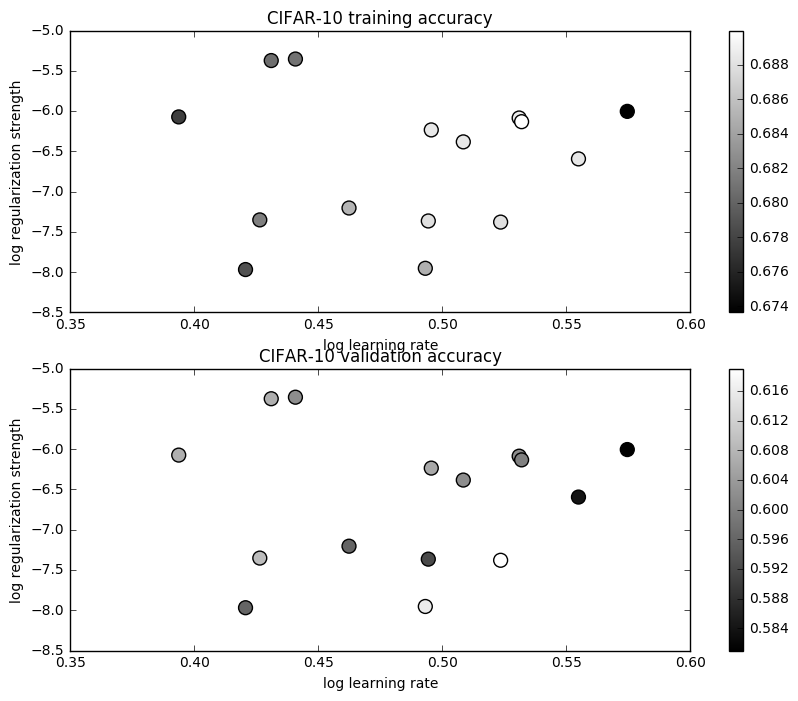

In [13]:
# Visualize the cross-validation results
x_scatter = [np.log10(x[0]) for x in results]
y_scatter = [np.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [x[2] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [x[3] for x in results]
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [14]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print test_acc

0.581


In [15]:
# Store the best HOG+Color net for later comparison
best_hc_test_acc = test_acc

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

*A very simple yet effective feature I implemented is to use the scores distribution from a softmax linear classifier operating on raw pixel input. While it might have a lower accuracy, the score/probability distribution can still effectively inform my neural network by working as a feature. We can note an average of 2-3% validation accuracy improvement even when using the same hyperparameters.*

In [16]:
# Load the best softmax model from the previous part of assignment
import pickle
best_softmax = pickle.load(open("best_softmax.p", "rb"))

In [17]:
# A function that obtains an image's softmax classifier scores
def softmax_scores(img):
    # Flatten the image vector and add bias
    img = img.reshape(1, -1)
    img = np.hstack([img, np.ones((1, 1))])
    
    # Calculate scores
    W = best_softmax.W
    return img.dot(W).flatten()

print softmax_scores(X_test[0])

[ 1.26554353 -0.45396007  0.30889811  0.49012312 -1.02027319  1.02035611
 -0.2571503  -1.40363927  1.53474494 -1.48464298]


In [18]:
num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins), softmax_scores]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [19]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
num_classes = 10

best_net = None

################################################################################
# Train a two-layer neural network on image features. You may want to          #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

from time import time

hidden_size = 256
batch_size = 2000
epochs = 30
iterations = int((50000/batch_size) * epochs)
networks = 15

best_val = -1
results = []

# Timing stuff
time_info = ''
tics = []

for i in xrange(networks):
    # Store current time in list for time estimation
    tics.append(time())
    
    # Pick a random learning rate and regularization strength
    lr = 10 ** np.random.uniform(0.35, 0.6)
    reg = 10 ** np.random.uniform(-8, -4)
    
    # Output
    print '{}/{} ... {}'.format(i+1, networks, time_info)
    
    # Create and train a network
    net = TwoLayerNet(input_dim, hidden_size, num_classes, dropout=True)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                      num_iters=iterations, batch_size=batch_size,
                      learning_rate=lr, learning_rate_decay=0.95,
                      reg=reg, verbose=False)
    
    # Evaluate the network
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    train_acc = (net.predict(X_train_feats) == y_train).mean()
    
    results.append((lr, reg, train_acc, val_acc, net))
    
    if val_acc > best_val:
        best_val = val_acc
        best_net = net
        best_stats = stats
    
    # Calculate time remaining estimate
    if len(tics) > 1:
        toc = time()
        time_elapsed = toc - tics[0]
        time_remaining = (toc - tics[i-1])/2 * (networks - i - 1)
        time_info = 'time elapsed: {:.2f}s estimated time remaining: {:.2f}s'.format(time_elapsed, time_remaining)
    
print '\n total elapsed time: {}s\n'.format(time() - tics[0])
    
# Print results in order
results = sorted(results, key=lambda x: x[3], reverse=True)
for i in xrange(len(results)):
    lr, reg, t_a, v_a, _ = results[i]
    print '%i lr %e reg %e train accuracy: %f val accuracy: %f' % (i+1, lr, reg, t_a, v_a)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

1/15 ... 
2/15 ... 
3/15 ... time elapsed: 57.27s estimated time remaining: 372.23s
4/15 ... time elapsed: 84.83s estimated time remaining: 339.57s


cs231n/classifiers/neural_net.py:120: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probabilities[np.arange(N), y])) / N


5/15 ... time elapsed: 114.19s estimated time remaining: 313.06s
6/15 ... time elapsed: 143.23s estimated time remaining: 292.02s
7/15 ... time elapsed: 171.84s estimated time remaining: 259.43s
8/15 ... time elapsed: 202.05s estimated time remaining: 235.27s
9/15 ... time elapsed: 233.02s estimated time remaining: 214.16s
10/15 ... time elapsed: 262.94s estimated time remaining: 182.66s
11/15 ... time elapsed: 294.37s estimated time remaining: 153.35s
12/15 ... time elapsed: 324.83s estimated time remaining: 123.79s
13/15 ... time elapsed: 355.82s estimated time remaining: 92.17s
14/15 ... time elapsed: 386.57s estimated time remaining: 61.74s
15/15 ... time elapsed: 418.51s estimated time remaining: 31.34s

 total elapsed time: 446.494830847s

1 lr 3.282195e+00 reg 3.971334e-06 train accuracy: 0.725143 val accuracy: 0.630000
2 lr 3.252317e+00 reg 1.762190e-05 train accuracy: 0.719265 val accuracy: 0.624000
3 lr 2.642710e+00 reg 4.655451e-07 train accuracy: 0.712939 val accuracy: 0.62

In [20]:
# Run your neural net classifier on the test set.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print "Best HOG+Color net test_acc:", best_hc_test_acc, "Best HOG+Color+Softmax net test_cc:", test_acc


Best HOG+Color net test_acc: 0.581 Best HOG+Color+Softmax net test_cc: 0.613
